In [1]:
expt_names = ["derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task"]

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.data.key_dataset import remove_overlaps, select_keys, create_windows, KeyDataset
from src.data.filter import Filter
from src.data.utils import bipolar_conversion, load_data, key_counts, load_data_deprecated
from src.visualization.visualize import layout
from src.utils import load_config
from src.models.keydecoder import KeyDecoder
from src.models.train import train
from src.models.utils import Experiment

import importlib
import operator
from functools import reduce

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
rhythm_layout = ['a', 's', 'd', 'f']
binary_layout = [0, 1]
right_layout = ['j', 'k', 'l', ';']
six_finger_layout = ['a', 's', 'd', 'f', 'g', 'h']
new_layout = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
two_fingers_layout = ['g', 'h']
window_pre = 800 #//2
window_post = 800 #//2
subwindow_len = 480 #//2

In [4]:
data_dir = "/home/john/rumi/data/"

def get_data(expt_list, layout, filter_params=None):
    datasets = []

    for expt_name in expt_list:
        key_fname = data_dir + expt_name + "/data_streams/key_stream.bin"
        emg_fname = data_dir + expt_name + "/data_streams/emg_stream.bin"
        key_data = load_data(key_fname)
        emg_data = load_data(emg_fname)
        emg_names = ['emgbuffer'] + list(emg_data.dtype.names)[1:]
        key_names = ['keybuffer'] + list(key_data.dtype.names)[1:]
        emg_data.dtype.names = emg_names
        key_data.dtype.names = key_names
        print([chr(i) for i in key_data['keybuffer'][:80, 1]])
        
#         print(emg_data.shape)
#         for i in range(0, 100):
#            print(emg_data[i][-1])
        new_key_data = np.zeros(key_data.size, 
                                dtype=[('keybuffer', '<i8', (3,)), ('emg_stream_step', '<i8'), ('key_stream_step', '<i8'), ('time_ns', '<i8')])
        new_key_data['keybuffer'] = np.concatenate((np.zeros_like(key_data['keybuffer'][:, 1:2]), 
                                                key_data['keybuffer']), axis=1)
        new_key_data['emg_stream_step'] = key_data['emg_stream_step']
        new_key_data['key_stream_step'] = key_data['key_stream_step']
        new_key_data['time_ns'] = key_data['time_ns']

        emg_stream = emg_data['emgbuffer']
        
        
        
#         for i in new_key_data:
#            if(i[0][1] != 0):
#                print(i)
        
        dataset = KeyDataset(emg_stream, new_key_data, layout, window_pre, window_post, subwindow_len,
                             start_channel=1, 
                             end_channel=65, bipolar=False, avg_ref=True, binary=True, 
                             include_blanks=True, 
                             limit_blanks=False,
                             filter_params=filter_params)

        datasets.append(dataset)
    full = reduce(operator.add, datasets)
    full.print_counts()
    data = full.to_numpy(include_full_windows=True)
    return data

In [5]:
#fs = 2000.0
#filter_params = {'fs': fs, 'fc': (10, min(1000.0, 0.5*fs - 1))}
fs = 4000.0
filter_params = None
print(filter_params)
data = get_data(expt_names, new_layout,filter_params=filter_params)
print(data.dtype)

None
['a', 'a', 'e', 'h', 'd', 'a', 'g', 'h', 'b', 'f', 'e', 'b', 'g', 'b', 'g', 'g', 'b', 'b', 'g', 'f', 'e', 'f', 'g', 'h', 'a', 'g', 'a', 'a', 'a', 'h', 'b', 'f', 'a', 'b', 'a', 'h', 'd', 'g', 'f', 'h', 'h', 'g', 'b', 'd', 'f', 'h', 'd', 'b', 'e', 'h', 'h', 'f', 'h', 'g', 'b', 'b', 'e', 'a', 'd', 'd', 'd', 'e', 'f', 'f', 'g', 'g', 'f', 'd', 'h', 'b', 'b', 'g', 'f', 'a', 'g', 'b', 'g', 'f', 'd', 'f']
0.0, NULL: 2097
1.0, : 699
[('full_windows', '<f8', (1600, 64)), ('emg_windows', '<f8', (480, 64)), ('start_idxs', '<i8'), ('key_label', '<f8')]


============= label =  1  ===========


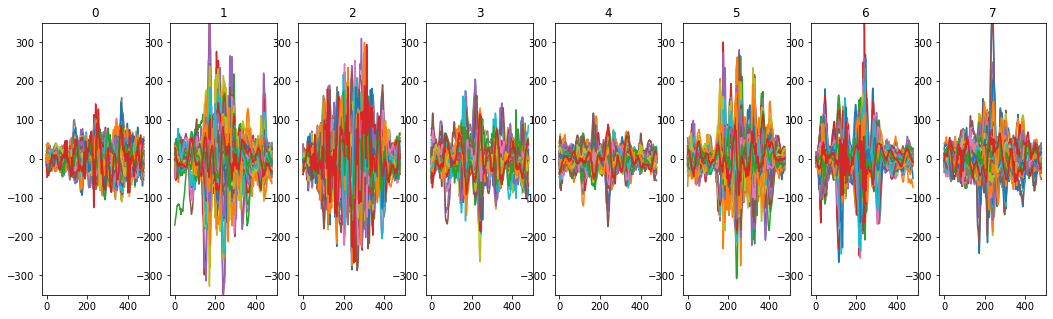

============= label =  0  ===========


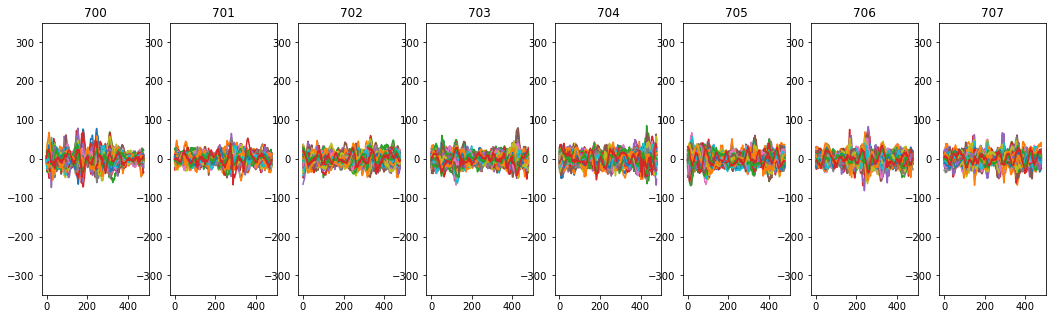

============= label =  1  ===========


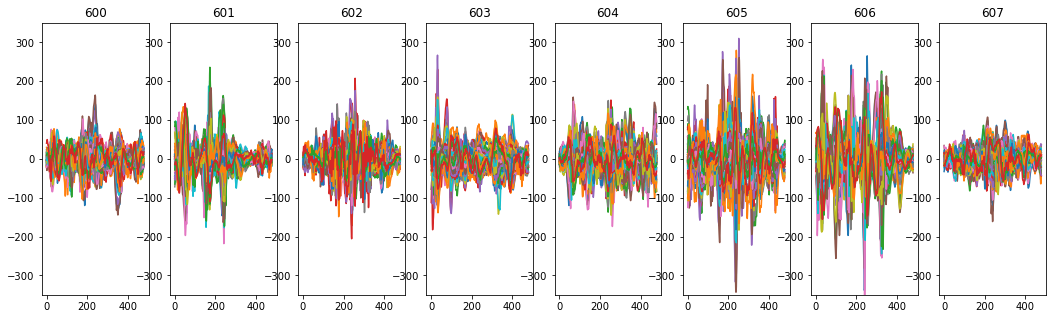

============= label =  0  ===========


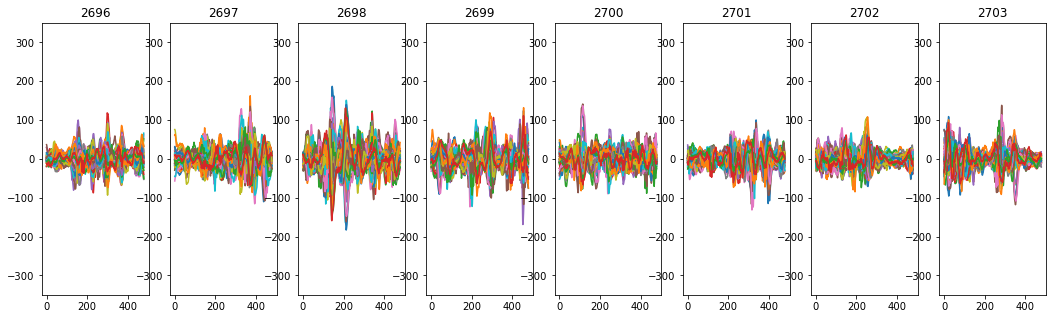

In [6]:
##VIS CODE
y = data['emg_windows']
x = np.arange(0, subwindow_len)

num_samples = y.shape[0]
# plot early data: 
def plot_emg(range_start, range_end, label = 1):
    num_plot = 8
    print('============= label = ', str(label), ' ===========')
    fig, axes = plt.subplots(1,num_plot)
    fig.set_size_inches(18 , 5, forward=True)
    subplot_tracker = 0
    for i in range(range_start, range_end): 
        row_plot = int(data['key_label'][i]) 
        if subplot_tracker > num_plot-1: 
            plt.show()
            break
        for j in range(0, 64):
            axes[ subplot_tracker ].plot(x, y[i, :, j])
        axes[ subplot_tracker ].set_ylim(-350,350)
        axes[ subplot_tracker ].set_title(str(i))        
        subplot_tracker = subplot_tracker + 1
    plt.show()
plot_emg(0,100,1)
plot_emg(700,800,0)


plot_emg(600, 700,1)
plot_emg(num_samples-100,num_samples-1,0)

In [7]:
config = load_config("/home/john/emg_decoder/configs/keydecoder.yaml")
#config['model']['data_scale'] = 1.0e6

In [8]:
train_data, val_test_data = train_test_split(data,
#                                             train_size=config['data']['train_proportion'],
                                             train_size=0.8,
#                                             stratify=data['key_label'],
                                            random_state=config['random_seed'])
relative_val_proportion = config['data']['val_proportion'] / (1 - config['data']['train_proportion'])

val_data, test_data = train_test_split(val_test_data,
                                      train_size=0.5,
                                       stratify=val_test_data['key_label'],
                                       random_state=config['random_seed'])


#test_data = data_test

# reinstantiate the a KeyDataset object to use the augmentation function, then convert to numpy again... 
# there's gotta be a better way...
train_dataset = KeyDataset(None, None, None, None, None, subwindow_len, init=False, binary=True)
train_dataset.full_windows = train_data['full_windows']
train_dataset.X = train_data['emg_windows']
train_dataset.start_idxs = train_data['start_idxs']
train_dataset.y = train_data['key_label']
train_dataset.num_chans = train_dataset.X.shape[-1]
train_dataset.print_counts()
target = 1500
for class_id in np.unique(train_dataset.y):
    train_dataset.augment_class(class_id, target_num_samples=target, num_views = 8, var_factor=4, time_shift=True, add_noise=True, in_place=True)
train_dataset.print_counts()
train_data = train_dataset.to_numpy(include_full_windows=False)

0.0, NULL: 1688
1.0, : 548
Already have 1688!
0.0, NULL: 1688
1.0, : 1500


In [9]:
name = expt_names[0] + "_binary"
# name = 'shreyas_testing_combined_balanced_noblanks'

print(name)
print(train_dataset.to_numpy(include_full_windows=False).size, val_data.size, test_data.size)
processed_data_dir = "/home/john/emg_decoder/data/processed/"
train_path = processed_data_dir + name + "_train.npy"
val_path = processed_data_dir + name + "_val.npy"
test_path = processed_data_dir + name + "_test.npy"
path = processed_data_dir + name
np.save(train_path, train_dataset.to_numpy(include_full_windows=False))
np.save(val_path, val_data)
##
##
np.save(test_path, test_data)

config['data']['window_length'] = subwindow_len
config['model']['loss'] = 'CrossEntropyLoss'
config['data']['train_path'] = train_path
config['data']['val_path'] = val_path
config['data']['test_path'] = test_path
config['name'] = name
config['root_dir'] = "/home/john/emg_decoder"

derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary
3188 280 280


In [10]:
system_type = KeyDecoder
experiment_dir = f"/home/john/emg_decoder/models/{config['name']}"
accelerator = 'cuda'
devices = [0]

system, trainer = train(
        system_type,
        config,
        experiment_dir=experiment_dir,
        accelerator=accelerator,
        devices=devices,
    run=True
    )

Seed set to 4995


/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy
data_scale tensor(1.)


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/john/emg_decoder/models/derek_d1_abh

/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


2024-09-26 14:36:10.420613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 14:36:10.503465: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params
---------------------------------------------
0 | loss  | CrossEntropyLoss   | 0     
1 | acc   | MulticlassAccuracy | 0     
2 | model | KeyClassifier      | 145 K 
---------------------------------------------
145 K     Trainable params
0         Non-trainable params
145 K     T

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

In [11]:
expt = Experiment(system_type, experiment_dir, version=0)
LIST_of_checkpoints = expt.list_checkpoints()
print(LIST_of_checkpoints)

Versions: ['0'] available, loading version 0...
['bell-epoch=09-val_loss=0.10.ckpt', 'bell-epoch=00-val_loss=0.11.ckpt', 'last.ckpt', 'bell-epoch=06-val_loss=0.06.ckpt', 'bell-epoch=02-val_loss=0.11.ckpt', 'bell-epoch=03-val_loss=0.11.ckpt']


bell-epoch=09-val_loss=0.10.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9678571224212646
        test_loss           0.15709669888019562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

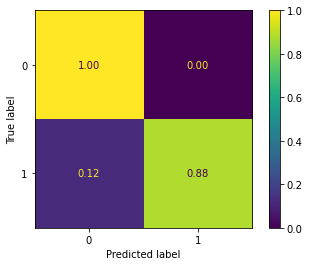

bell-epoch=00-val_loss=0.11.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9607142806053162
        test_loss           0.1177634671330452
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

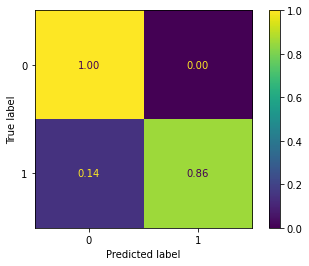

last.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9785714149475098
        test_loss           0.10923667252063751
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

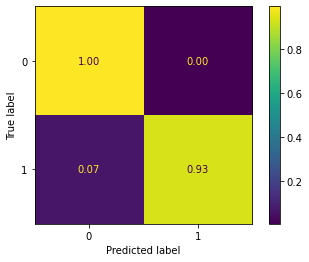

bell-epoch=06-val_loss=0.06.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9678571224212646
        test_loss           0.13025695085525513
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

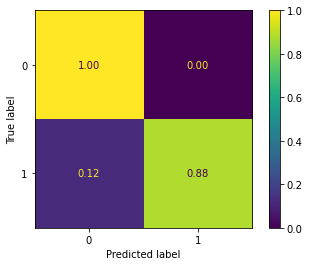

bell-epoch=02-val_loss=0.11.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9642857313156128
        test_loss           0.1173185333609581
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

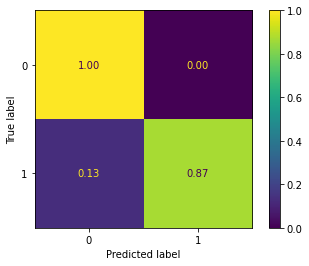

bell-epoch=03-val_loss=0.11.ckpt
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9750000238418579
        test_loss           0.08104812353849411
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

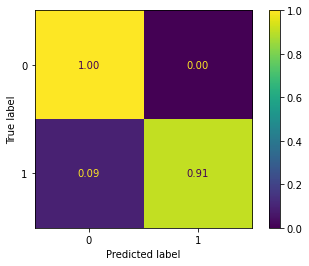

/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy
data_scale tensor(1.)
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                        | 0/? [00:00…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9785714149475098
        test_loss           0.10923667252063751
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
/home/john/emg_decoder/data/processed/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary_test.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                     | 0/? [00:00…

best ckpt:  [{'test_loss': 0.10923667252063751, 'test_acc': 0.9785714149475098}]


In [12]:
best_ckpt = ''
best_acc = 0
for ckpt in LIST_of_checkpoints: 
    print(ckpt)
    system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + ckpt, strict=False)
    ret = trainer.test(system)
    if ret[0]['test_acc'] > best_acc:
        best_ckpt = ckpt
        best_acc = ret[0]['test_acc'] 
    out = trainer.predict(system)
    ys = np.concatenate([a[1] for a in out])
    preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])
    disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f')
    plt.show()
system=KeyDecoder.load_from_checkpoint(experiment_dir + "/models/" + best_ckpt, strict=False)
test_perf = trainer.test(system)
out = trainer.predict(system)
print('best ckpt: ', test_perf)

(280, 2) (280,)


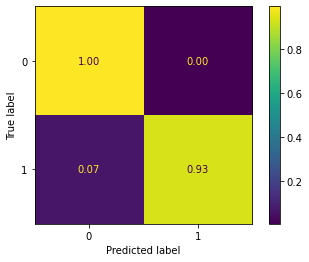

In [13]:
Xs = np.concatenate([a[0] for a in out])
ys = np.concatenate([a[1] for a in out])
print(Xs.shape, ys.shape)
preds = np.hstack([torch.argmax(a[0], axis=1) for a in out])
disp = ConfusionMatrixDisplay.from_predictions(ys, preds, normalize='true', values_format='.2f')

In [14]:
torch.save(system.state_dict(), f"{experiment_dir}/models/{config['name']}.pt")
print(f"experiment_directory: {experiment_dir}")
print(f"checkpoint_name: {config['name']}.pt")

experiment_directory: /home/john/emg_decoder/models/derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary
checkpoint_name: derek_d1_abhishek_offline_2024-09-26-1419_Rhythm-Game-Typing-Task_binary.pt


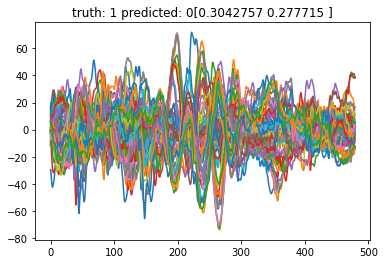

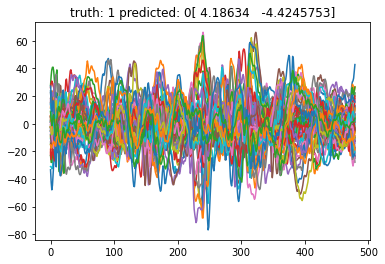

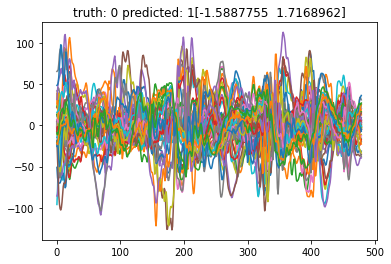

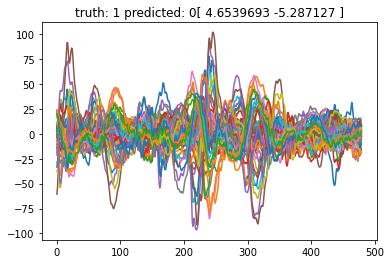

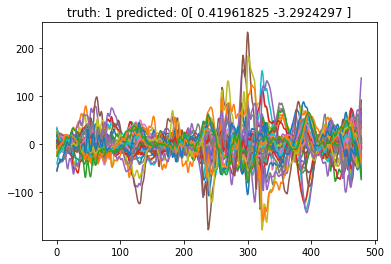

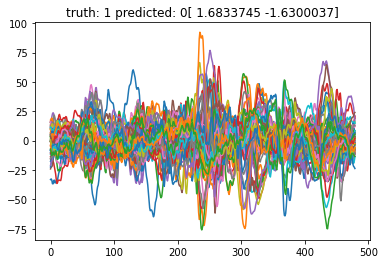

In [15]:
##Plot errors
x = np.arange(0, subwindow_len)
y = test_data['emg_windows']
for i in range(len(ys)):
    if(ys[i] != preds[i]):
        plt.figure(i)

        temp = "truth: " + str(ys[i]) + " predicted: " + str(preds[i]) + str(Xs[i])
        plt.title(temp)

        for j in range(1, 64):
            plt.plot(x, y[i, :, j])
        plt.show()

In [16]:
typing_test_layout = [65505, 'a', 'w', 'd', ' ', 'j', 'i', 'o', ';']
asciis = [ord(ch) if type(ch) == str else ch for ch in new_layout]
print(asciis)
idxs = np.argsort(asciis)
# idxs = [0, 2, 3, 4, 5, 1]
print(np.argsort(asciis))
print(np.unique(ys))
reord_ys = np.array([idxs[i] for i in ys])
reord_preds = np.array([idxs[i] for i in preds])
print(reord_ys)
print(preds)

[97, 98, 99, 100, 101, 102, 103, 104]
[0 1 2 3 4 5 6 7]
[0 1]
[0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0]
[0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 